# Correlations

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm

//anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## A gaussian with correlations

We wish to sample a 2D Posterior which looks something like below. Here the x and y axes are parameters.

<function matplotlib.pyplot.xlim>

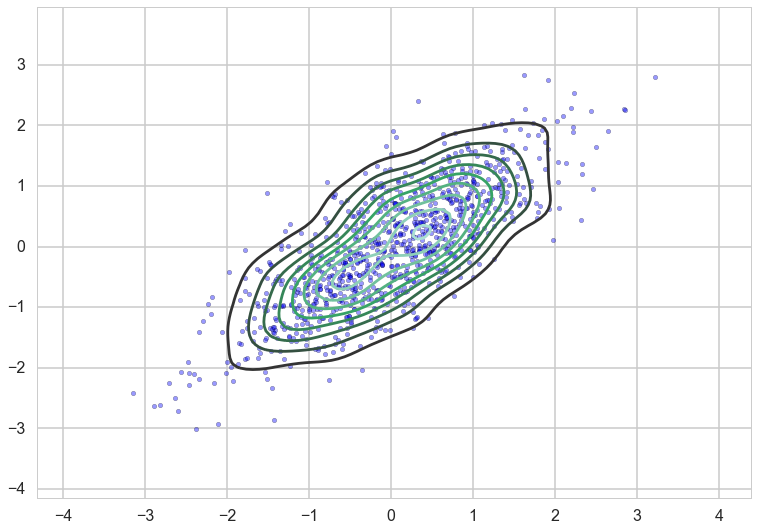

In [2]:
cov=np.array([[1,0.8],[0.8,1]])
data = np.random.multivariate_normal([0,0], cov, size=1000)
sns.kdeplot(data);
plt.scatter(data[:,0], data[:,1], alpha=0.4)
plt.xlim

In [ ]:
#from https://stats.stackexchange.com/questions/260764/bayesian-correlation-matrix-estimation-with-heteroscedastic-uncertainties



In [56]:
import theano.tensor as tt
def pm_make_cov(sigpriors, corr_coeffs, ndim):
    sigma_matrix = tt.nlinalg.diag(sigpriors)
    n_elem = int(ndim * (ndim - 1) / 2)
    tri_index = np.zeros([ndim, ndim], dtype=int)
    tri_index[np.triu_indices(ndim, k=1)] = np.arange(n_elem)
    tri_index[np.triu_indices(ndim, k=1)[::-1]] = np.arange(n_elem)
    corr_matrix = corr_coeffs[tri_index]
    corr_matrix = tt.fill_diagonal(corr_matrix, 1)
    return tt.nlinalg.matrix_dot(sigma_matrix, corr_matrix, sigma_matrix)

In [24]:
sigs=np.array([1,1])


In [25]:
tri_index = np.zeros([2, 2], dtype=int)
tri_index

array([[0, 0],
       [0, 0]])

In [26]:
with pm.Model() as modelmvg: 
    nu = pm.Uniform('nu', 1, 5)  # prior on how much correlation (0 = uniform prior on correlation, oo = no correlation)
    ndim=2
    corr_coeffs = pm.LKJCorr('corr_coeffs', nu, ndim) 
    cov = pm_make_cov(sigs, corr_coeffs)
    mvg = pm.MvNormal('mvg', mu=[0,0], cov=cov, shape=2, observed=data)

In [27]:
advifit2 = pm.variational.advi( model=modelmvg, n=100000)

Average ELBO = -2,487.9:  13%|█▎        | 13148/100000 [00:05<00:35, 2466.39it/s]4, 2228.80it/s]


In [28]:
mus2, sds2, elbo2 = advifit2
mus2

{'corr_coeffs_interval_': array([ 2.17362892]),
 'nu_interval_': array(-1.5325777474832887)}

In [32]:
from pymc3.distributions.transforms import Interval
I=Interval(-1,1)
I.backward(mus2['corr_coeffs_interval_']).eval()

array([ 0.79571251])

In [30]:
with modelmvg:
    nutstrace = pm.sample(10000)

100%|██████████| 10000/10000 [00:35<00:00, 285.03it/s]


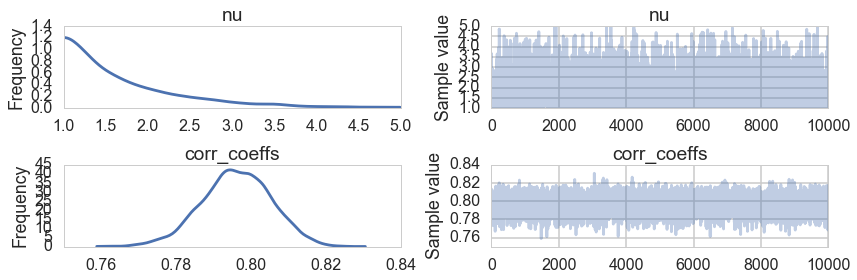

In [31]:
pm.traceplot(nutstrace);

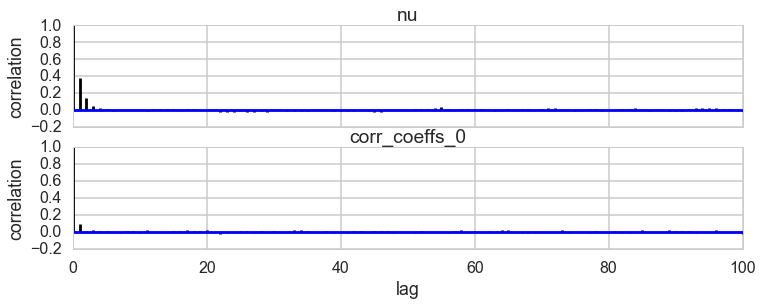

In [33]:
pm.autocorrplot(nutstrace);

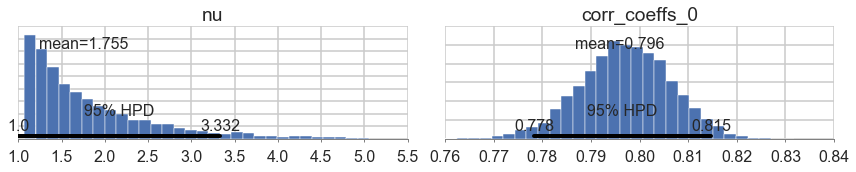

In [34]:
pm.plot_posterior(nutstrace);

In [57]:
with pm.Model() as modelmvg2: 
    nu = pm.Uniform('nu', 1, 5)  # prior on how much correlation (0 = uniform prior on correlation, oo = no correlation)
    ndim=2
    sigs = pm.Lognormal('sigma', np.zeros(2), np.ones(2), shape=2)
    corr_coeffs = pm.LKJCorr('corr_coeffs', nu, ndim) 
    cov = pm_make_cov(sigs, corr_coeffs, ndim)
    mvg = pm.MvNormal('mvg', mu=[0,0], cov=cov, shape=2, observed=data)

In [58]:
with modelmvg2:
    nutstrace2 = pm.sample(10000)

100%|██████████| 10000/10000 [00:42<00:00, 233.41it/s]


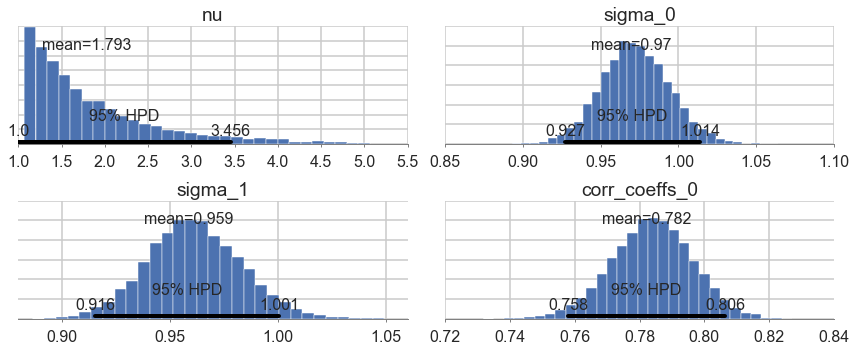

In [59]:
pm.plot_posterior(nutstrace2);